<a href="https://colab.research.google.com/github/javadvahid/deepLearning/blob/main/MaskRCNNPytorchMultipleClasses.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget http://sceneparsing.csail.mit.edu/data/ChallengeData2017/images.tar
!wget http://sceneparsing.csail.mit.edu/data/ChallengeData2017/annotations_instance.tar
!tar -xf images.tar
!tar -xf annotations_instance.tar
!rm images.tar annotations_instance.tar
!pip install -qU torch_snippets
!wget --quiet https://raw.githubusercontent.com/pytorch/vision/release/0.12/references/detection/engine.py
!wget --quiet https://raw.githubusercontent.com/pytorch/vision/release/0.12/references/detection/utils.py
!wget --quiet https://raw.githubusercontent.com/pytorch/vision/release/0.12/references/detection/transforms.py
!wget --quiet https://raw.githubusercontent.com/pytorch/vision/release/0.12/references/detection/coco_eval.py
!wget --quiet https://raw.githubusercontent.com/pytorch/vision/release/0.12/references/detection/coco_utils.py
!pip install -q -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

--2024-01-27 09:35:08--  http://sceneparsing.csail.mit.edu/data/ChallengeData2017/images.tar
Resolving sceneparsing.csail.mit.edu (sceneparsing.csail.mit.edu)... 128.30.100.223
Connecting to sceneparsing.csail.mit.edu (sceneparsing.csail.mit.edu)|128.30.100.223|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 892088320 (851M) [application/x-tar]
Saving to: ‘images.tar’

images.tar          100%[===================>] 850.76M  2.56MB/s    in 5m 43s  

2024-01-27 09:40:52 (2.48 MB/s) - ‘images.tar’ saved [892088320/892088320]

--2024-01-27 09:40:52--  http://sceneparsing.csail.mit.edu/data/ChallengeData2017/annotations_instance.tar
Resolving sceneparsing.csail.mit.edu (sceneparsing.csail.mit.edu)... 128.30.100.223
Connecting to sceneparsing.csail.mit.edu (sceneparsing.csail.mit.edu)|128.30.100.223|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 90398720 (86M) [application/x-tar]
Saving to: ‘annotations_instance.tar’

annotations_instanc 100

In [2]:
import os
from torch_snippets import *
import glob
import torchvision
import torch
import cv2
import numpy as np
import tqdm
from PIL import Image
import random
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from engine import train_one_epoch, evaluate
import utils
import transforms as T
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
all_images = glob.glob('images/training/*.*')
all_annots = glob.glob('annotations_instance/training/*.*')

In [ ]:
print(all_images[:5])

[
    'images/training/ADE_train_00013426.jpg',
    'images/training/ADE_train_00003784.jpg',
    'images/training/ADE_train_00002419.jpg',
    'images/training/ADE_train_00013706.jpg',
    'images/training/ADE_train_00002444.jpg'
]

In [ ]:
print(all_annots[:5])

[
    'annotations_instance/training/ADE_train_00016725.png',
    'annotations_instance/training/ADE_train_00016114.png',
    'annotations_instance/training/ADE_train_00007103.png',
    'annotations_instance/training/ADE_train_00013365.png',
    'annotations_instance/training/ADE_train_00009555.png'
]

In [ ]:
all_images[0].split('/')

['images', 'training', 'ADE_train_00020058.jpg']

[1 2 3]

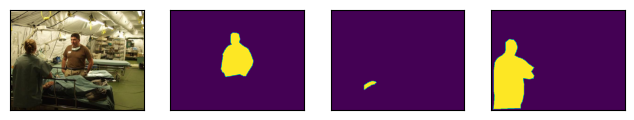

In [4]:
impath = 'images/training/ADE_train_00011779.jpg'
anpath = 'annotations_instance/training/ADE_train_00011779.png'
im = cv2.imread(impath)
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
an = cv2.imread(anpath)#.transpose(2, 0, 1)
an = cv2.cvtColor(an, cv2.COLOR_BGR2RGB).transpose(2, 0, 1)
r, g, b = an
nzs = np.nonzero(r==4)
instances = np.unique(g[nzs])
print(instances)
masks = np.zeros((len(instances), *r.shape))
for ix, _id in enumerate(instances):
  masks[ix] = g==_id
idx = 1
fig = plt.figure(figsize=(10, 2))
for img in [im, *masks]:
  ax = fig.add_subplot(1, 5, idx)
  ax.imshow(img)
  ax.set_xticks([])
  ax.set_yticks([])
  idx += 1
plt.show()

In [ ]:
im.shape

(432, 576, 3)

In [5]:
classes_list = [4, 6]
annots = []
for ann in tqdm.tqdm(all_annots):
  _ann = cv2.imread(ann)
  _ann = cv2.cvtColor(_ann, cv2.COLOR_BGR2RGB).transpose(2, 0, 1)
  r, g, b = _ann
  if np.array([num in np.unique(r) for num in classes_list]).sum()==0: continue
  annots.append(ann)

100%|██████████| 20210/20210 [03:20<00:00, 100.92it/s]


In [6]:
from sklearn.model_selection import train_test_split
_annots = []
for item in annots:
  _annots.append(os.path.basename(item)[:-4])
trn_items, val_items = train_test_split(_annots, random_state=2)

In [ ]:
trn_items[:5]

['ADE_train_00012087',
 'ADE_train_00019694',
 'ADE_train_00005926',
 'ADE_train_00010938',
 'ADE_train_00015702']

In [17]:
def get_transform(train):
  transforms = []
  transforms.append(T.ToTensor())
  if train:
    transforms.append(T.RandomHorizontalFlip(0.5))
  return T.Compose(transforms)

class MaskDataset(Dataset):
  def __init__(self, items, transforms, N):
    self.items = items
    self.transforms = transforms
    self.N = N
  def get_mask(self, path):
    an = cv2.imread(path)#.transpose(2, 0, 1)
    an = cv2.cvtColor(an, cv2.COLOR_BGR2RGB).transpose(2, 0, 1)
    r, g, b = an
    cls = list(set(np.unique(r)).intersection({4, 6}))
    masks = []
    labels = []
    for _cls in cls:
      nzs = np.nonzero(r==_cls)
      instances = np.unique(g[nzs])
      for ix, _id in enumerate(instances):
        masks.append(g==_id)
        labels.append(classes_list.index(_cls) + 1)
    return np.array(masks), np.array(labels)
  def __getitem__(self, ix):
    _id = self.items[ix]
    img_path = f'images/training/{_id}.jpg'
    mask_path = f'annotations_instance/training/{_id}.png'
    masks, labels = self.get_mask(mask_path)
    obj_ids = np.arange(1, len(masks)+1)
    img = Image.open(img_path).convert('RGB')
    num_objs = len(obj_ids)
    boxes = []
    for i in range(num_objs):
      obj_pixels = np.where(masks[i])
      #masks shape: H * W
      xmin = np.min(obj_pixels[1])
      xmax = np.max(obj_pixels[1])
      ymin = np.min(obj_pixels[0])
      ymax = np.max(obj_pixels[0])

      if (((xmax-xmin)<=10) or (ymax-ymin)<=10):
        xmax = xmin + 10
        ymax = ymin + 10
      boxes.append([xmin, ymin, xmax, ymax])
    boxes = torch.as_tensor(boxes, dtype=torch.float32)
    labels = torch.as_tensor(labels, dtype=torch.int64)
    masks = torch.as_tensor(masks, dtype=torch.uint8)
    area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
    iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
    image_id = torch.tensor([ix])
    target = {}
    target["boxes"] = boxes
    target['labels'] = labels
    target["masks"] = masks
    target["image_id"] = image_id
    target['area'] = area
    target['iscrowd'] = iscrowd
    if self.transforms is not None:
      img, target = self.transforms(img, target)
    return img, target
  def __len__(self):
    return self.N

  def choose(self):
    return self[random.randint(len(self))]


In [8]:
x = MaskDataset(trn_items, get_transform(train=True), N=100)
image, targ = x[0]


In [9]:
image.shape

torch.Size([3, 512, 768])

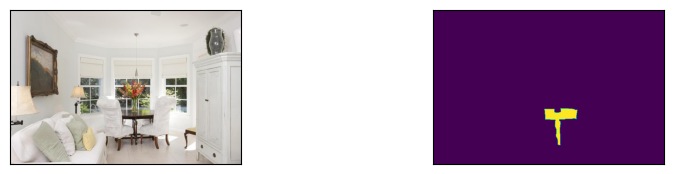

In [10]:
idx = 1
fig = plt.figure(figsize=(10, 2))
for img in [np.array(image).transpose(1, 2, 0), *targ['masks']]:
  ax = fig.add_subplot(1, len(targ['masks'])+1, idx)
  ax.imshow(img)
  ax.set_xticks([])
  ax.set_yticks([])
  idx += 1
plt.show()

In [11]:
def get_model_instance_segmentation(num_classes):
  model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
  in_features = model.roi_heads.box_predictor.cls_score.in_features
  model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
  in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
  hidden_layer = 256
  model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)
  return model

In [18]:
model = get_model_instance_segmentation(3).to(device)
model

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [19]:
dataset = MaskDataset(trn_items, get_transform(train=True), N=3000)
dataset_test = MaskDataset(val_items, get_transform(train=False), N=800)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True, num_workers=0, collate_fn=utils.collate_fn)
dataloader_test = DataLoader(dataset_test, batch_size=1, shuffle=False, num_workers=0, collate_fn=utils.collate_fn)

In [20]:
num_classes = 3
model = get_model_instance_segmentation(num_classes).to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [21]:
num_epochs = 5
trn_history = []
for epoch in range(num_epochs):
  res = train_one_epoch(model, optimizer, dataloader, device, epoch, print_freq=10)
  trn_history.append(res)
  #print(res.meters['loss'])
  lr_scheduler.step()
  res = evaluate(model, data_loader=dataloader_test, device=device)

Epoch: [0]  [   0/1500]  eta: 0:18:31  lr: 0.000010  loss: 3.2528 (3.2528)  loss_classifier: 0.9144 (0.9144)  loss_box_reg: 0.3845 (0.3845)  loss_mask: 1.9299 (1.9299)  loss_objectness: 0.0187 (0.0187)  loss_rpn_box_reg: 0.0052 (0.0052)  time: 0.7408  data: 0.0226  max mem: 4315
Epoch: [0]  [  10/1500]  eta: 0:15:59  lr: 0.000060  loss: 2.8100 (3.0491)  loss_classifier: 0.9144 (0.8873)  loss_box_reg: 0.2442 (0.2895)  loss_mask: 1.6323 (1.7972)  loss_objectness: 0.0339 (0.0404)  loss_rpn_box_reg: 0.0052 (0.0347)  time: 0.6439  data: 0.0625  max mem: 4315
Epoch: [0]  [  20/1500]  eta: 0:15:22  lr: 0.000110  loss: 2.6624 (2.7867)  loss_classifier: 0.7235 (0.7301)  loss_box_reg: 0.2378 (0.2880)  loss_mask: 1.4769 (1.5833)  loss_objectness: 0.0376 (0.1499)  loss_rpn_box_reg: 0.0096 (0.0354)  time: 0.6175  data: 0.0482  max mem: 4486
Epoch: [0]  [  30/1500]  eta: 0:15:10  lr: 0.000160  loss: 1.8869 (2.3689)  loss_classifier: 0.4267 (0.5991)  loss_box_reg: 0.2670 (0.3035)  loss_mask: 0.7990 (

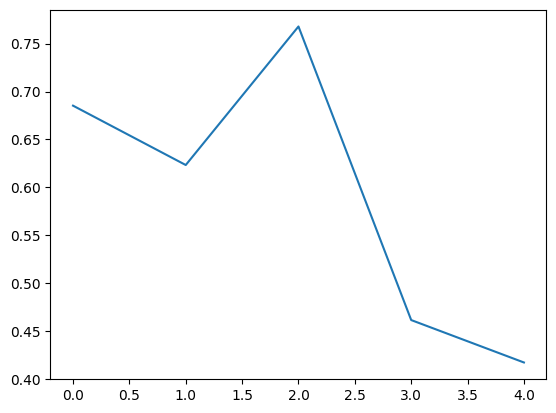

In [22]:
losses = [np.mean(list(trn_history[i].meters['loss'].deque)) for i in range(len(trn_history))]
plt.plot(losses)

torch.Size([3, 512, 683])

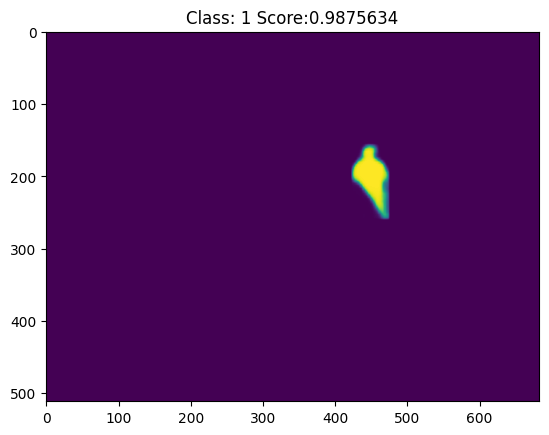

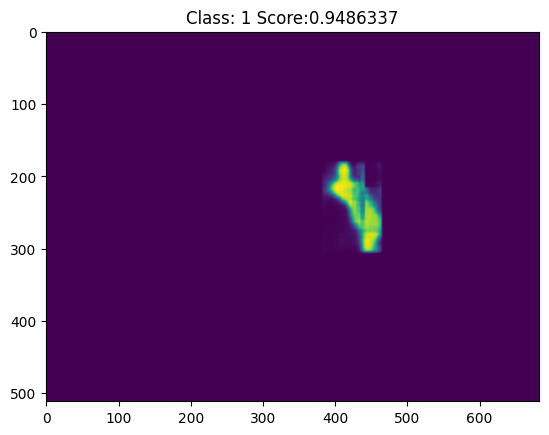

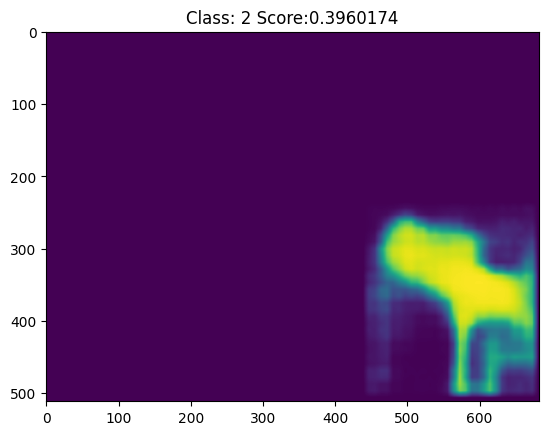

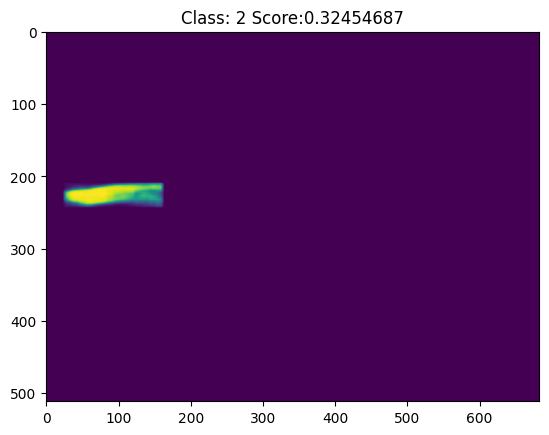

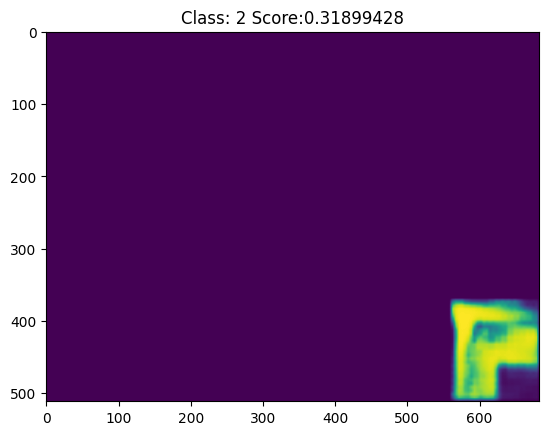

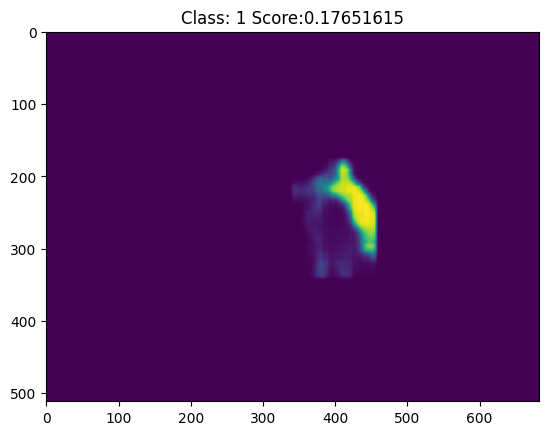

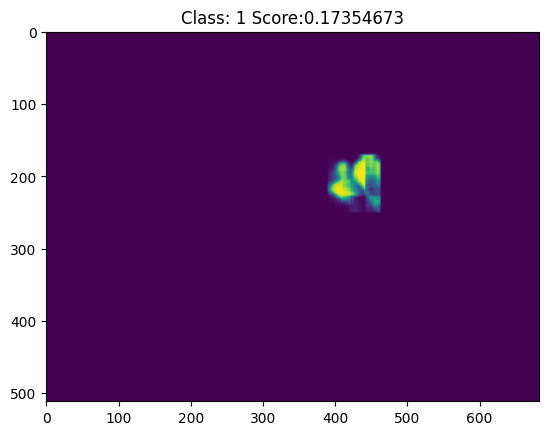

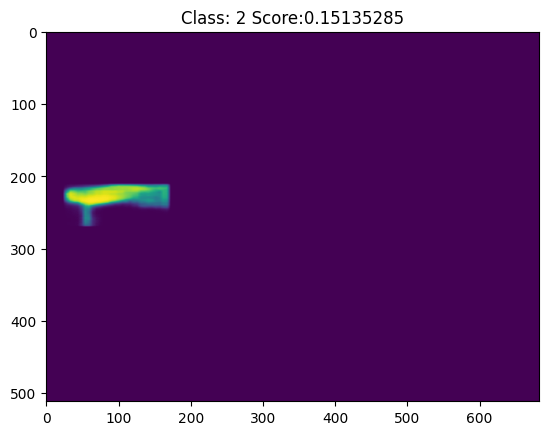

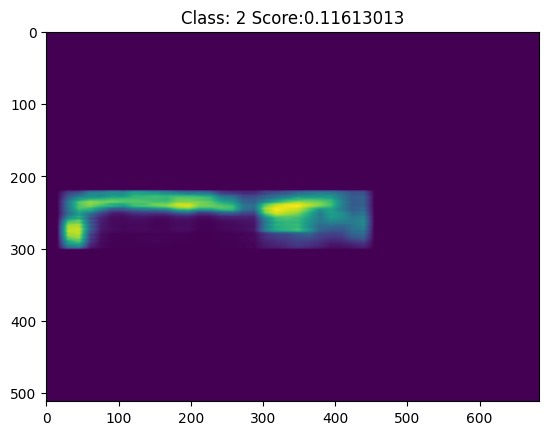

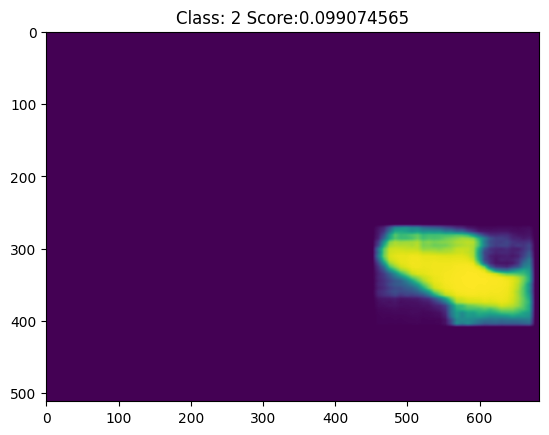

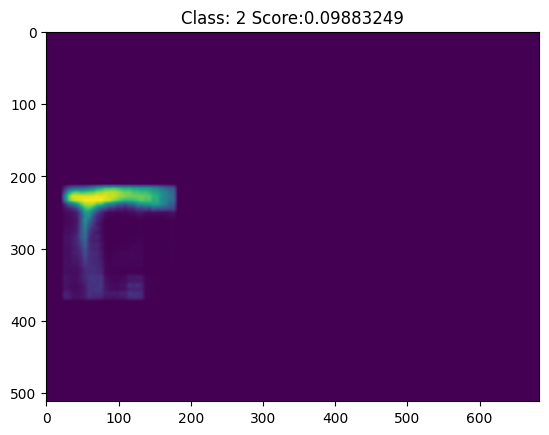

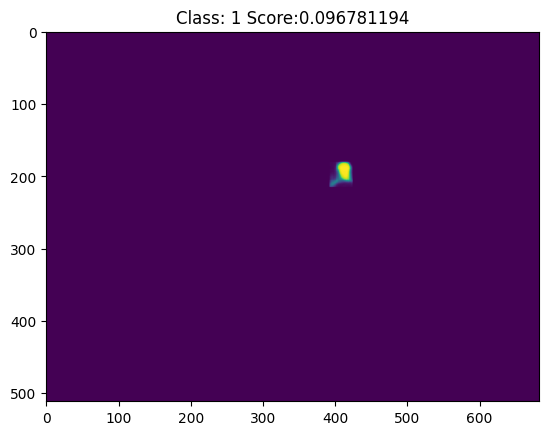

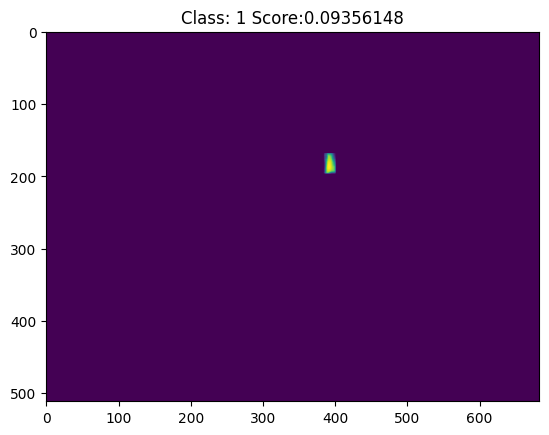

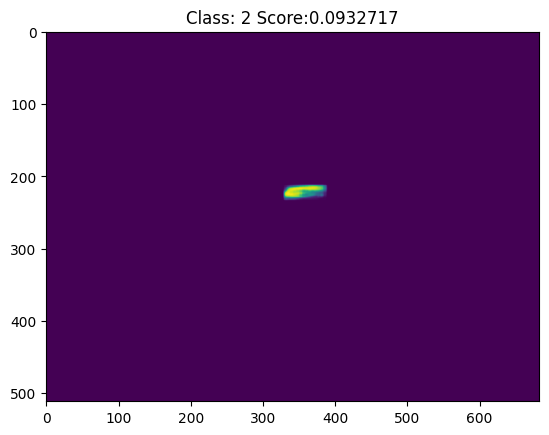

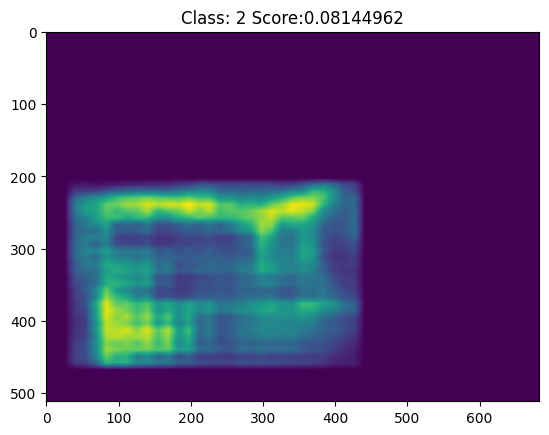

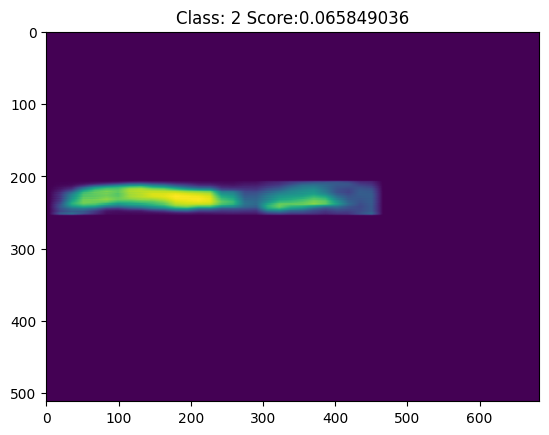

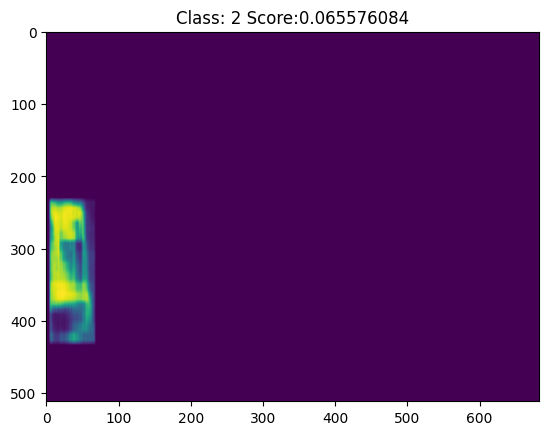

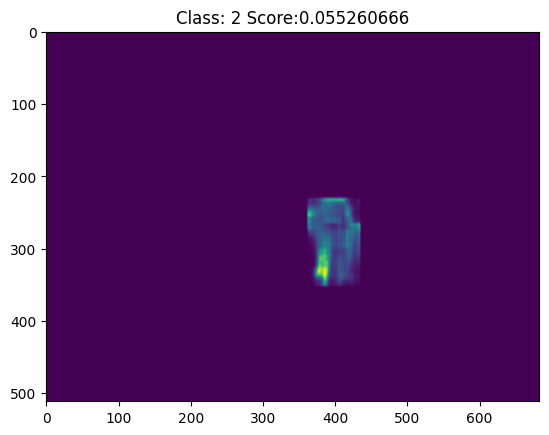

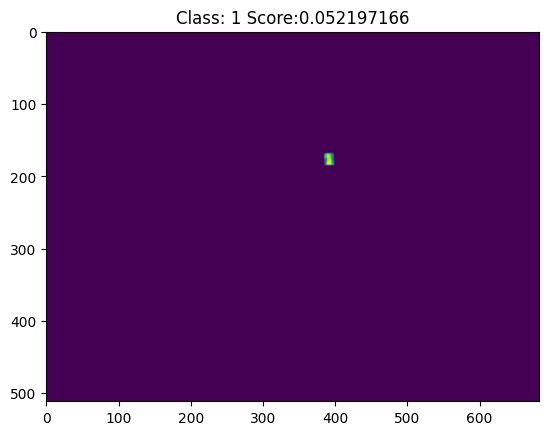

In [26]:
model.eval()
im = dataset_test[0][0]
print(im.shape)
imtest = im.permute(1, 2, 0)
plt.imshow(imtest)
with torch.no_grad():
  prediction = model([im.to(device)])
  for i in range(len(prediction[0]['masks'])):
    plt.imshow(Image.fromarray(prediction[0]['masks'][i, 0].mul(255).byte().cpu().numpy()))
    plt.title('Class: ' + str(prediction[0]['labels'][i].cpu().numpy()) + ' Score:' +\
              str(prediction[0]['scores'][i].cpu().numpy()))
    plt.show()

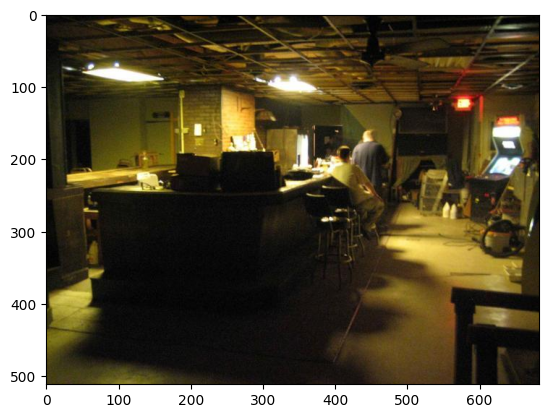

In [27]:
plt.imshow(imtest)